# Basic workflow with ManGO

## Authentication with iCommands

<div class="alert alert-block alert-info">
<h3>Every seven days</h3>
    
1. Go to https://mango.kuleuven.be/
2. In the tab of your zone, click on "How to connect"
3. Copy the snippet provided under "iCommands Client on Linux".

<font size=3>Then **paste the snippet** in the cell below, right under `%%bash`, like the (anonimized) example below.</font>

(Replacing the `USERNAME` with your username and the `TOKEN` with the password provided by "How to connect" should also work.)

**You don't need to do this every time: The authentication lasts 7 days.**
</div>

In [ ]:
%%bash
mkdir -p ~/.irods
cat > ~/.irods/irods_environment.json <<'EOF'
{
    "irods_host": "ghum.irods.icts.kuleuven.be",
    "irods_port": 1247,
    "irods_zone_name": "ghum",
    "irods_authentication_scheme": "pam_password",
    "irods_encryption_algorithm": "AES-256-CBC",
    "irods_encryption_salt_size": 8,
    "irods_encryption_key_size": 32,
    "irods_encryption_num_hash_rounds": 8,
    "irods_user_name": "USERNAME",
    "irods_ssl_ca_certificate_file": "",
    "irods_ssl_verify_server": "cert",
    "irods_client_server_negotiation": "request_server_negotiation",
    "irods_client_server_policy": "CS_NEG_REQUIRE",
    "irods_default_resource": "default",
    "irods_cwd": "/ghum/home"
}
EOF
iinit -h | grep Version | grep -v -q 4.2. || sed -i 's/"irods_authentication_scheme": "pam_password"/"irods_authentication_scheme": "PAM"/' ~/.irods/irods_environment.json
echo 'TOKEN' | iinit --ttl 168 >/dev/null && echo You are now authenticated to irods. Your session is valid for 168 hours.
ils

## Setting up

The first step _in each session_ is to set up ManGO (and load any other libraries you need).

In [1]:
import os
import ssl
from irods.session import iRODSSession
try:
    env_file = os.environ['IRODS_ENVIRONMENT_FILE']
except KeyError:
    env_file = os.path.expanduser('~/.irods/irods_environment.json')

ssl_context = ssl.create_default_context(
        purpose=ssl.Purpose.SERVER_AUTH,
        cafile=None, capath=None, cadata=None
        )
ssl_settings = {'ssl_context': ssl_context}

Since we are working interactively we will create an `irods.session.iRODSSession` object and then close it at the end of the notebook with `session.cleanup()`. If you were working on a script, you could run all your code inside a `with` statement.

In [2]:
session = iRODSSession(irods_env_file=env_file, **ssl_settings)

The final step to set up your environment is to define your working directory in a variable. For this notebook, it's "/ghum/home/ghum_pilot034/", but for your own project it might be different.

In [3]:
home_dir = "/ghum/home/ghum_pilot034/"

You will need all the code above at the start of any notebook that needs to connect to ManGO.

--------------

The code below is illustration of basic functions to communicate with ManGO; take them as a cheatsheet and use them at your convenience.

## Collections

You can connect to a specific iRODS collection with `session.collections.get("/path/to/collection")`; this could be your home collection, project collection or any other sub-collection. After you instantiate the collection you prefer, you can see some basic information about it. The `subcollections` and `data_objects` attributes return lists of the sub-collections and data objects of this instantiated collection. Methods that will be discussed below allow you to create, move and remove the collection as well.

Let's retrieve our existing home collection:

In [4]:
coll = session.collections.get(home_dir)
coll

<iRODSCollection 32803 b'ghum_pilot034'>

In [5]:
coll.path

'/ghum/home/ghum_pilot034'

The subcollections and data objects contained in a collection can be retrieved with the `subcollections` and `data_objects` attributes, respectively. We can also use the `.walk()` method to get the full tree.

<div class="alert alert-block alert-info">
<b>Note</b>: Your output will be different depending on your reading permissions; you'll only see the dataset that you have access to and the collection of your team.
</div>

In [6]:
coll.subcollections

[<iRODSCollection 32809 b'DATASET_1'>,
 <iRODSCollection 36802 b'DATASET_2'>,
 <iRODSCollection 41041 b'DATASET_3'>,
 <iRODSCollection 41032 b'DATASET_4'>,
 <iRODSCollection 41053 b'DATASET_5'>,
 <iRODSCollection 41023 b'DATASET_6'>,
 <iRODSCollection 41062 b'DATASET_7'>]

In [7]:
coll.subcollections[0].subcollections[0].subcollections[0].data_objects[:5]

[<iRODSDataObject 36715 FL5069879_6246_DIGI_0005_0005_000001_VIEW_MAIN.jpg>,
 <iRODSDataObject 36754 FL5069880_6247_DIGI_0005_0005_000002_VIEW_MAIN.jpg>,
 <iRODSDataObject 36691 FL5069881_6248_DIGI_0005_0005_000003_VIEW_MAIN.jpg>,
 <iRODSDataObject 36775 FL5069882_6249_DIGI_0005_0005_000004_VIEW_MAIN.jpg>,
 <iRODSDataObject 36757 FL5069883_6250_DIGI_0005_0005_000005_VIEW_MAIN.jpg>]

In [8]:
for item in coll.subcollections[0].walk():
    print(f"{item[0]} contains {len(item[1])} subcollections and {len(item[2])} data objects.")
    if len(item[1]) == 1:
        print("The subcollection is:", item[1][0])
    if len(item[2]) == 1:
        print("The data object is:", item[2][0])
    print()

<iRODSCollection 32809 b'DATASET_1'> contains 1 subcollections and 0 data objects.
The subcollection is: <iRODSCollection 32812 b'IE5069877'>

<iRODSCollection 32812 b'IE5069877'> contains 1 subcollections and 1 data objects.
The subcollection is: <iRODSCollection 32815 b'REP5069878'>
The data object is: <iRODSDataObject 33007 manifest.json>

<iRODSCollection 32815 b'REP5069878'> contains 0 subcollections and 663 data objects.



## Editing data objects and collections in ManGO

This section shows how to create new collections and data objects, upload local data to ManGO and remove data objects from ManGO.
This section will be showcased in a dummy folder ("team_dummy").

In [9]:
dummy_team_dir = home_dir + 'team_dummy/'
dummy_coll = session.collections.create(dummy_team_dir) # this won't work if you created it before
dummy_coll.path

'/ghum/home/ghum_pilot034/team_dummy'

In [10]:
dummy_coll.data_objects

[]

In [11]:
# create a new collection
session.collections.create(dummy_team_dir + 'new_collection2')
dummy_coll.subcollections

[<iRODSCollection 3413326 b'new_collection2'>]

In [12]:
# create a new data object
session.data_objects.create(dummy_team_dir + 'new_object.txt')
dummy_coll.data_objects

[<iRODSDataObject 3413329 new_object.txt>]

When you have results to upload to ManGO you should save your output locally and then send it to ManGO with `iput()`.

Here we upload a file called "test.txt" to the dummy directory and also call it "test.txt" in ManGO.

In [13]:
# send a local file
session.data_objects.put('test.txt', dummy_team_dir + 'test.txt')
dummy_coll.data_objects

[<iRODSDataObject 3413329 new_object.txt>, <iRODSDataObject 3413332 test.txt>]

Data objects can be removed from ManGO with `unlink()`. The `force` argument indicates whether it should be permanently deleted (`True`) or sent to trash (`False`). Objects in the trash get removed automatically after 14 days.

In [14]:
# remove data objects
session.data_objects.unlink(dummy_team_dir + 'new_object.txt', force=True)
dummy_coll.data_objects

[<iRODSDataObject 3413332 test.txt>]

## Download data from ManGO

In order to access the data you have on ManGO, you should download it with `get()`. If you provide a second argument with a local path, next to obtaining the normal information about the object you will also download it.

In [15]:
destination_path = 'downloaded_object.txt' # local path

In [17]:
session.data_objects.get(dummy_team_dir + 'test.txt', destination_path)
os.path.exists(destination_path)

True

Once you have download the file you can use normal Python commands to do something with it, like read the contents of a text file or show an image.

In [18]:
with open(destination_path, 'r') as f:
    mytext = f.readlines()
print(mytext)

['This is a text file that goes back and forth between my local space and ManGO :)']


In [19]:
image_from_mango = coll.subcollections[0].subcollections[0].subcollections[0].data_objects[30]
image_from_mango.path

'/ghum/home/ghum_pilot034/DATASET_1/IE5069877/REP5069878/FL5069909_6276_DIGI_0005_0005_000031_VIEW_MAIN.jpg'

In [21]:
session.data_objects.get(image_from_mango.path, 'some_image.jpg')

<iRODSDataObject 36181 FL5069909_6276_DIGI_0005_0005_000031_VIEW_MAIN.jpg>

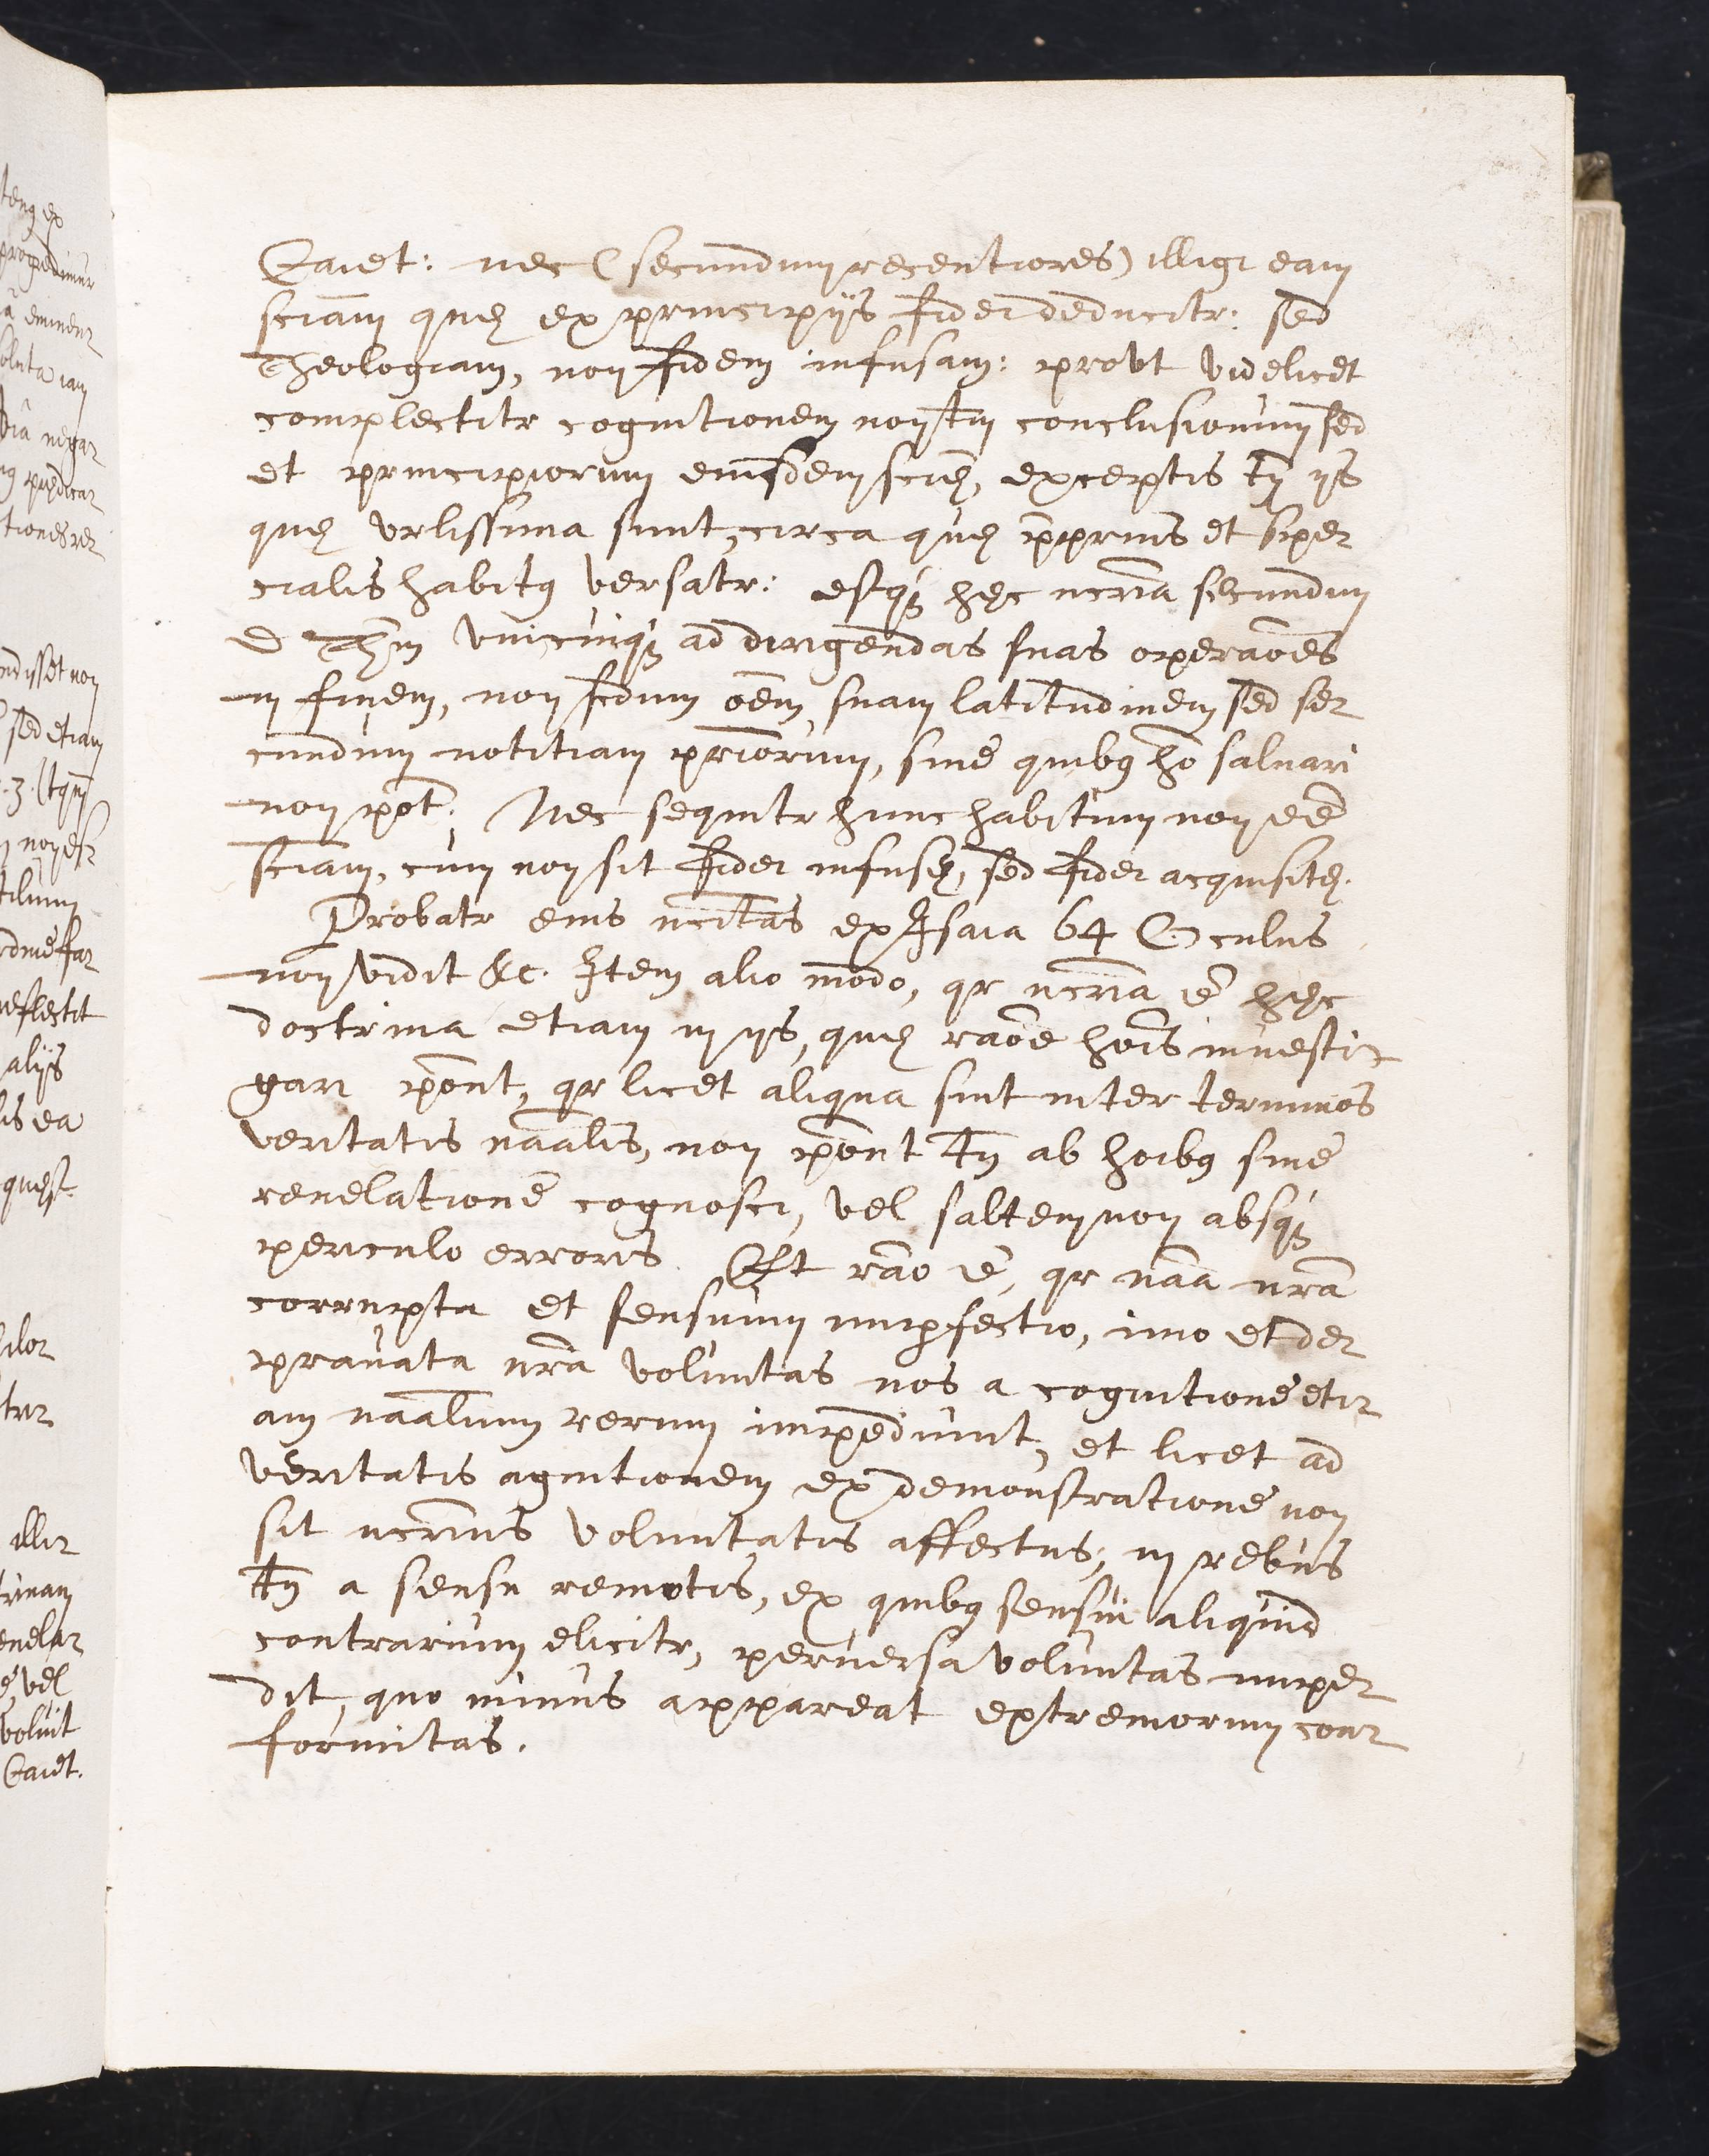

In [22]:
from IPython import display
display.Image("some_image.jpg")

## Metadata

An important feature of ManGO is the ability to add metadata to collections and data objects. There are two main ways to do that:

- If you add or remove few items, you can use the `.add()` and `.remove()` methods of the `metadata` attributes.
- If you need to add or remove many items at once, it's best to use atomic operations, which allows you to send multiple operations in one server call, making it much faster.

The main arguments here are the elements of the metadata tuples: **Attribute (name), value and units**.

In [23]:
# assign data object to a variable
obj = session.data_objects.get(dummy_team_dir + 'test.txt')
obj.metadata.items()

[]

### Individual operations 

In [24]:
# add new metadata
obj.metadata.add('ingredient', 'sugar', 'brown')
obj.metadata.add('ingredient', 'egg')
obj.metadata.add('flavor', 'chocolate', 'dark')
obj.metadata.add('flavor', 'orange')
obj.metadata.add('type', 'cake')
obj.metadata.items()

[<iRODSMeta 63118 ingredient sugar brown>,
 <iRODSMeta 63121 ingredient egg None>,
 <iRODSMeta 63124 flavor chocolate dark>,
 <iRODSMeta 63127 flavor orange None>,
 <iRODSMeta 63130 type cake None>]

In [25]:
# modify existing metadata
from irods.meta import iRODSMeta
new_meta = iRODSMeta('ingredient', 'flour', 'all_purpose')
new_meta
new_meta.name
obj.metadata[new_meta.name] = new_meta
obj.metadata.items()

[<iRODSMeta 63124 flavor chocolate dark>,
 <iRODSMeta 63127 flavor orange None>,
 <iRODSMeta 63130 type cake None>,
 <iRODSMeta 63148 ingredient flour all_purpose>]

In [26]:
# remove single metadata field
obj.metadata.remove('ingredient', 'flour', 'all_purpose')
obj.metadata.items()

[<iRODSMeta 63124 flavor chocolate dark>,
 <iRODSMeta 63127 flavor orange None>,
 <iRODSMeta 63130 type cake None>]

In [27]:
# remove all metadata
obj.metadata.remove_all()
obj.metadata.items()

[]

A collection can also have metadata.

In [28]:
dummy_coll.metadata.items()

[]

In [29]:
dummy_coll.metadata.add('register', 'recipes')
dummy_coll.metadata.add('has_ocr', 'false')
dummy_coll.metadata.add('goal', 'training')
dummy_coll.metadata.items()

[<iRODSMeta 63253 register recipes None>,
 <iRODSMeta 63256 has_ocr false None>,
 <iRODSMeta 63259 goal training None>]

### Atomic operations
Atomic operations allow you to add and remove multiple metadata items in one call. They require importing the `AVUOperation` class.

In [30]:
from irods.meta import AVUOperation
obj.metadata.apply_atomic_operations(
    AVUOperation(operation='remove', avu=iRODSMeta('taste', '4', 'stars')),
    AVUOperation(operation='add', avu=iRODSMeta('type', 'cake')),
    AVUOperation(operation='add', avu=iRODSMeta('ingredient', 'chocolate', 'dark')),
    AVUOperation(operation='add', avu=iRODSMeta('ingredient', 'flour', 'self-rising')),
    AVUOperation(operation='add', avu=iRODSMeta('ingredient', 'eggs', '5')),
    AVUOperation(operation='add', avu=iRODSMeta('ingredient', 'sugar', 'brown')),
    AVUOperation(operation='remove', avu=iRODSMeta('ingredient', 'chocolate', 'dark'))
    )
obj.metadata.items()

[<iRODSMeta 63118 ingredient sugar brown>,
 <iRODSMeta 63130 type cake None>,
 <iRODSMeta 63154 ingredient flour self-rising>,
 <iRODSMeta 63157 ingredient eggs 5>]

This becomes particularly useful if you have a JSON file, for example, with attribute-value pairs to assign as metadata.

In [31]:
import json
with open('metadata.json') as jfile:
    jobj = json.load(jfile)
jobj

{'country': 'Belgium',
 'date': '2023-02-17',
 'format': 'ipynb',
 'python-version': '3.9.12'}

In [32]:
obj.metadata.remove_all()
obj.metadata.apply_atomic_operations(*[
    AVUOperation(operation='add',
                 avu=iRODSMeta(str(item[0]), str(item[1]))
                ) for item in jobj.items()
])
obj.metadata.items()

[<iRODSMeta 63160 country Belgium None>,
 <iRODSMeta 63163 date 2023-02-17 None>,
 <iRODSMeta 63166 format ipynb None>,
 <iRODSMeta 63169 python-version 3.9.12 None>]

## Queries

We can run queries with `session.query()`, which collects information from collections, data objects, and their metadata with specific classes. More interestingly, we can filter that information based on certain Criteria.


Class | Information about | Useful attributes
---- | ------ | ----------
`Collection` | A collection | `name`, `owner_name`, `id` ...
`DataObject` | A data object | `name`, `path`, `size`, `owner_name`, `id` ...
`CollectionMeta` | The metadata of a collection | `name`, `value`, `units`, ...
`DataObjectMeta` | The metadata of a data object | `name`, `value`, `units`, ...

In [33]:
from irods.models import Collection, DataObject, CollectionMeta, DataObjectMeta
from irods.column import Criterion

The following query retrieves all the collections inside our project collection (`home_dir`), regardless of their depth, and prints their paths.

In [34]:
query = session.query(Collection.name)
for result in query:
    if result[Collection.name].startswith(home_dir):
        print(result[Collection.name])

/ghum/home/ghum_pilot034/DATASET_1
/ghum/home/ghum_pilot034/DATASET_1/IE5069877
/ghum/home/ghum_pilot034/DATASET_1/IE5069877/REP5069878
/ghum/home/ghum_pilot034/DATASET_2
/ghum/home/ghum_pilot034/DATASET_2/IE3562253
/ghum/home/ghum_pilot034/DATASET_2/IE3562253/REP3562255
/ghum/home/ghum_pilot034/DATASET_3
/ghum/home/ghum_pilot034/DATASET_3/IE10071724
/ghum/home/ghum_pilot034/DATASET_3/IE10071724/REP10071732
/ghum/home/ghum_pilot034/DATASET_4
/ghum/home/ghum_pilot034/DATASET_4/IE4984790
/ghum/home/ghum_pilot034/DATASET_4/IE4984790/OCR
/ghum/home/ghum_pilot034/DATASET_4/IE4984790/REP4984791
/ghum/home/ghum_pilot034/DATASET_5
/ghum/home/ghum_pilot034/DATASET_5/IE2546128
/ghum/home/ghum_pilot034/DATASET_5/IE2546128/OCR
/ghum/home/ghum_pilot034/DATASET_5/IE2546128/REP2546129
/ghum/home/ghum_pilot034/DATASET_6
/ghum/home/ghum_pilot034/DATASET_6/IE10589074
/ghum/home/ghum_pilot034/DATASET_6/IE10589074/REP10589075
/ghum/home/ghum_pilot034/DATASET_6/IE10589074/REP10589077
/ghum/home/ghum_pilot0

In the cells below, we request the path of our collections and the names and date of creation of our data objects.
Then we filter the results based on the following criteria:

- The collection path has to end in "OCR" ('like' + '%OCR')
- The data object name has to end in ".xml" ('like' + '%.xml')
- The data object has to have more than 8000 bytes ('>' + 8000)
- The data object must have been created before '2023-01-27 13:45:25'.
    + In order to define the date-time threshold we use the `datetime` library.

In [35]:
import datetime

In [36]:
threshold = datetime.datetime.fromisoformat('2023-01-27 13:45:25')

In [37]:
ocr_files = session.query(Collection.name, DataObject.name, DataObject.create_time).filter(
    Criterion('like', Collection.name, '%OCR')).filter(
    Criterion('like', DataObject.name, '%.xml')).filter(
    Criterion('>', DataObject.size, 8000)).filter(
    Criterion('<', DataObject.create_time, threshold))
for item in ocr_files:
    print(item[DataObject.name], item[Collection.name], item[DataObject.create_time])

FL4984792.xml /ghum/home/ghum_pilot034/DATASET_4/IE4984790/OCR 2023-01-27 13:44:44
FL2546133.xml /ghum/home/ghum_pilot034/DATASET_5/IE2546128/OCR 2023-01-27 13:45:11
FL9411144.xml /ghum/home/ghum_pilot034/DATASET_7/IE9410642/OCR 2023-01-27 13:45:24
FL9411152.xml /ghum/home/ghum_pilot034/DATASET_7/IE9410642/OCR 2023-01-27 13:45:24
FL9411153.xml /ghum/home/ghum_pilot034/DATASET_7/IE9410642/OCR 2023-01-27 13:45:23


The `.execute()` method returns a printable table with the columns requested in `.query()`.

In [38]:
print(ocr_files.execute())

+--------------------------------------------------+---------------+---------------+
| COLL_NAME                                        | DATA_NAME     | D_CREATE_TIME |
+--------------------------------------------------+---------------+---------------+
| /ghum/home/ghum_pilot034/DATASET_4/IE4984790/OCR | FL4984792.xml | 01674827084   |
| /ghum/home/ghum_pilot034/DATASET_5/IE2546128/OCR | FL2546133.xml | 01674827111   |
| /ghum/home/ghum_pilot034/DATASET_7/IE9410642/OCR | FL9411144.xml | 01674827124   |
| /ghum/home/ghum_pilot034/DATASET_7/IE9410642/OCR | FL9411152.xml | 01674827124   |
| /ghum/home/ghum_pilot034/DATASET_7/IE9410642/OCR | FL9411153.xml | 01674827123   |
+--------------------------------------------------+---------------+---------------+


And of course, we can also run queries based on the metadata. We can both find collections and data objects based on their own metadata but also data objects based on the metadata of their parent collections and collections based on the metadata of their data objects.

The query below returns the name of all data objects and the name and value of their metadata as long as the name of the metadata field contains "python".

In [39]:
python_version = session.query(DataObject.name, DataObjectMeta.name, DataObjectMeta.value).filter(
    Criterion('like', DataObjectMeta.name, '%python%'))
print(python_version.execute())

+-----------+-------------------------+--------------------------+
| DATA_NAME | COL_META_DATA_ATTR_NAME | COL_META_DATA_ATTR_VALUE |
+-----------+-------------------------+--------------------------+
| test.txt  | python-version          | 3.9.12                   |
+-----------+-------------------------+--------------------------+


The cell below returns data objects and the metadata information _of their parent collection_ as long as the name of the metadata field (of the collection) is "goal".

In [40]:
col_meta = session.query(DataObject, CollectionMeta).filter(
    Criterion('=', CollectionMeta.name, 'goal'))
for item in col_meta:
    print(f"{item[DataObject.path]} is inside a collection with a meta data field '{item[CollectionMeta.name]}' with value '{item[CollectionMeta.value]}'.")

/data/home/ghum_pilot034/team_dummy/test.txt is inside a collection with a meta data field 'goal' with value 'training'.


The cell below returns collections and the metadata of their data objects as long as the value of the metadata field (of the data object) is "Belgium".

In [41]:
dobj_meta = session.query(Collection, DataObjectMeta).filter(
    Criterion('=', DataObjectMeta.value, 'Belgium'))
for item in dobj_meta:
    print(f"{item[Collection.name]} contains a data object with a field '{item[DataObjectMeta.name]}' with value '{item[DataObjectMeta.value]}'.")

/ghum/home/ghum_pilot034/team_dummy contains a data object with a field 'country' with value 'Belgium'.


## CLEAN UP 
<div class="alert alert-block alert-warning">
    <font size=4><b>Do not forget to clean up your session!</b></font>
</div>

In [42]:
# leave this cell at the end and running every time you are done
session.cleanup()